In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import seaborn as sns
from time import perf_counter
import xgboost as xgb
from joblib import Parallel, delayed
from numpy import linalg as LA
import pandas as pd
from scipy.signal import butter, lfilter, freqz
import src.utils.preprocess as pre
from tst import Transformer
# from tst import Transformer_with_sst
import os
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.neural_network import MLPRegressor

Download only sst data (365 days per year)

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# train_data = train_data.to(device)

In [4]:
device

device(type='cuda')

In [5]:
(X_train, y_train), (X_test, y_test) = pre.create_dataset(n_comp=20,n_sst_comp=20,target_variable='precip')

In [6]:
X_train.shape, X_test.shape

((9934, 40), (2456, 40))

In [7]:
y_test.shape

(2456, 3274)

In [8]:
y_test[:,509].shape

(2456,)

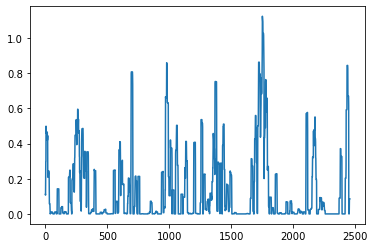

In [9]:
plt.plot(np.log10(y_test[:,509].reshape((-1,1)) + 1.0))

In [10]:
y_train = y_train[:,509].reshape((-1,1))
y_test = y_test[:,509].reshape((-1,1))

In [11]:
X_mins = np.amin(X_train,axis=0)
# y_min = np.amin(y_train,axis=0)
X_train = X_train - X_mins
X_test = X_test - X_mins
# y_train = y_train - y_min
# y_test = y_test - y_min
X_maxs = np.amax(X_train,axis=0)
# y_max = np.amax(y_train,axis=0)
X_train = X_train/X_maxs
X_test = X_test/X_maxs
# y_train = y_train/y_max
# y_test = y_test/y_max

In [12]:
np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test)


(0.0, 1.0, -0.08301995004894765, 1.0356012691558016)

In [13]:
y_train = np.log10(y_train + 1.0)
y_test = np.log10(y_test + 1.0) 

In [14]:
np.min(y_train)

0.0

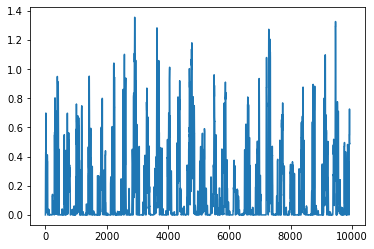

In [15]:
plt.plot(y_train)

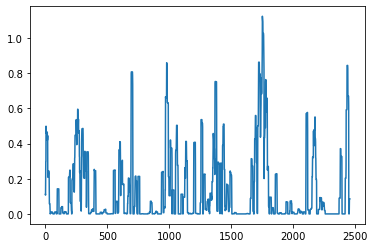

In [16]:
plt.plot(y_test )

In [17]:
y_train.shape

(9934, 1)

In [18]:
X_train.shape, X_test.shape

((9934, 40), (2456, 40))

In [19]:
X_total = np.concatenate((X_train,X_test),axis=0)
y_total = np.concatenate((y_train,y_test),axis=0)

In [20]:
y_total.shape

(12390, 1)

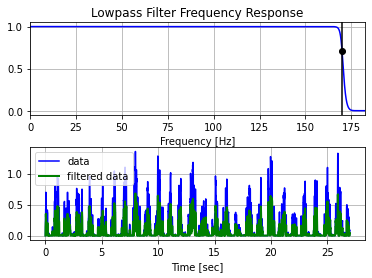

In [21]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 10
fs = 365      # sample rate, Hz
cutoff = 170 # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()


# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 27         # seconds
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
data = y_total[0:9855]

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

res = np.zeros((y_total.shape[0],1))
res[0:9855] = y
res[9855:] = y[-(y_total.shape[0]-9855):]
trend = res

r-sq on train: 0.6435897235839194
r-sq on test: -0.12502166306827456
cosine_similarity on train: [[1.]]
cosine_similarity on test: [[0.48972045]]


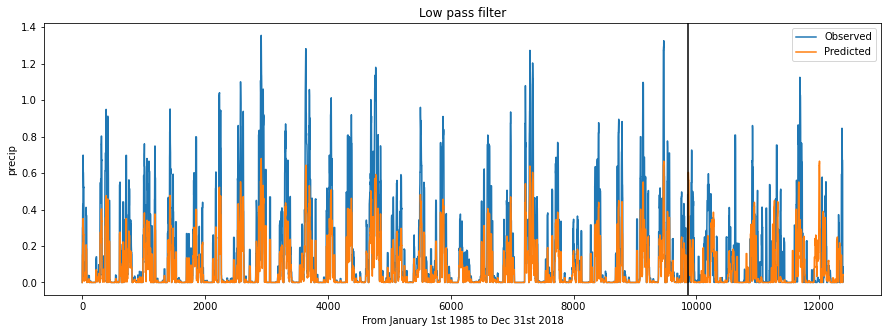

In [22]:
print('r-sq on train:', r2_score(y_total[:9855], res[:9855]))
print('r-sq on test:', r2_score(y_total[9855:],  res[9855:]))
print('cosine_similarity on train:', cosine_similarity(y_total[:9855].reshape((1,-1)), res[:9855].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_total[9855:].reshape((1,-1)),  res[9855:].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_total,label='Observed')
plt.plot(res,label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel('precip')
plt.title('Low pass filter')
plt.axvline(x=9855,c='black');

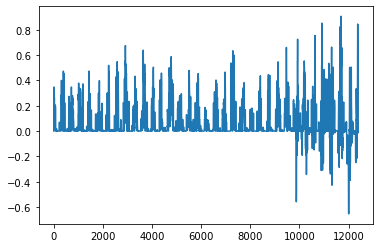

In [23]:
#Detrend!
y_total = y_total - trend
plt.plot(y_total)

In [25]:
data_total = np.concatenate((X_total[28:],y_total[:-28]),axis=1)

In [26]:
train_range = int(0.8*data_total.shape[0])
train_data_array = data_total[0:train_range]
test_data_array = data_total[train_range:]

In [27]:
train_data_array.shape, test_data_array.shape

((9889, 41), (2473, 41))

In [28]:
# train_data_array = np.concatenate((X_train, y_train), axis=1)
# test_data_array = np.concatenate((X_test, y_test), axis=1)

In [29]:
train_data = torch.FloatTensor(train_data_array)
y_train = torch.FloatTensor(y_train)

In [30]:
class SimpleDataset(Dataset):
    def __init__(self, data):
        self.samples = data

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [31]:
def create_sequence(input_data, train_window, pred_window):  #  Create sequences of observations for training
    seq = []
    L = len(input_data)
    feature_size = input_data[0].shape[0]
    print('feature_size', feature_size)
    for i in range(L - train_window-pred_window):
        train_seq = input_data[i:i+train_window]
        train_label = input_data[i+train_window+pred_window-1,feature_size-1] # get y_t+14
#         train_label = input_data[i + train_window + pred_window]
        seq.append((train_seq ,train_label))
        
    print('train_seq, train_label', train_seq.shape, train_label.shape)
    return seq

In [32]:
train_window = 90
pred_window = 28
train_seq = create_sequence(train_data, train_window, pred_window)

feature_size 41
train_seq, train_label torch.Size([90, 41]) torch.Size([])


In [33]:
from torch.utils.data import Dataset, DataLoader

class SeqDataset(Dataset):
    def __init__(self, seq_data, transform=None):
        
        self.seq_data = seq_data
        self.x = []
        self.y = []
        for i in range(len(self.seq_data)):
            self.x.append(self.seq_data[i][0])
            self.y.append(self.seq_data[i][1])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return (self.x[idx], self.y[idx])

    def __len__(self):
        return len(train_seq) #self._x.shape[0]

In [34]:
dataset_train = SeqDataset(train_seq)
dataloader_train = DataLoader(dataset_train,
                              batch_size=128,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )

In [35]:
d_input = 41 # From dataset
d_output = 1 # From dataset

attention_size = 8
LR = 1e-5 #1e-3
d_model = 64
q = 8 # Query size
v = 8 # Value size
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
dropout = 0.2 # Dropout rate
# pe = 'original' # Positional encoding
chunk_mode = None
net = Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, 
                  dropout=dropout, chunk_mode=chunk_mode, pe='regular', pe_period=2, seq_length=90).to(device)
# net = nn.Sequential(Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, 
#                   dropout=dropout, chunk_mode=chunk_mode, pe=pe),
#                     nn.Flatten(),
#                     nn.Linear(30, 1),
#                    ).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = nn.MSELoss() #OZELoss(alpha=0.3)

[Epoch  90/90]: 100%|██████████| 9771/9771 [00:07<00:00, 1330.33it/s, loss=0.00774]


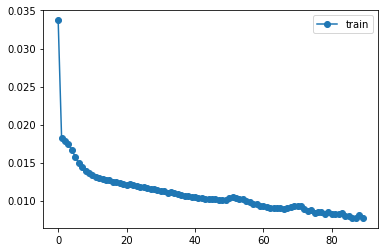

In [36]:
EPOCHS = 90
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)

for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(train_seq), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y_label) in enumerate(dataloader_train):
#             x = x.unsqueeze(0)
            y_label = y_label.view(-1,1)
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Compute loss
#             print(netout, y)
            loss = loss_function(y_label.to(device), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
                
#         scheduler.step()    
        train_loss = running_loss/len(dataloader_train)
#         print('pred, target', netout, y)
#         val_loss = compute_loss(net, dataloader_val, loss_function, device).item()
#         pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        if idx_epoch % 10 ==0 or idx_epoch == EPOCHS-1:
            pbar.set_postfix({'loss': train_loss})

        hist_loss[idx_epoch] = train_loss
#         hist_loss_val[idx_epoch] = val_loss

#         if val_loss < val_loss_best:
#             val_loss_best = val_loss
#             torch.save(net.state_dict(), model_save_path)
        
plt.plot(hist_loss, 'o-', label='train')
# plt.plot(hist_loss_val, 'o-', label='val')
plt.legend()
# print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

In [47]:
train_test_total = np.concatenate((train_data_array, test_data_array))

net.eval()
num_pred = 1 #  Number of prediction forward, i.e. tau
res = np.zeros(train_window).tolist()
#  Predicting y using X_test and y_test
for i in tqdm(range(train_test_total.shape[0]-train_window)):
    for j in range(num_pred):
        seq = torch.FloatTensor(train_test_total[i:i+train_window]).to(device)
        seq = seq.unsqueeze(0)
        #print(seq)
        with torch.no_grad():
            #print(model(seq))
            pred = net(seq).cpu()
            #print(len(test_inputs))
            res.append(pred)
            
res = np.array(res)

100%|██████████| 12272/12272 [03:06<00:00, 65.66it/s]


In [48]:
y_all = np.concatenate((y_train.cpu(), y_test))[:-28]

In [50]:
res.shape,y_all.shape,trend.shape

((12362,), (12362, 1), (12390, 1))

In [51]:
res = res.reshape((-1,1)) + trend[:-28]

In [55]:
test_size = y_test.shape[0]
target = 'precip'

r-sq on train: 0.6537657736057922
r-sq on test: -0.3895114141580014
cosine_similarity on train: [[0.88835878]]
cosine_similarity on test: [[0.55862013]]


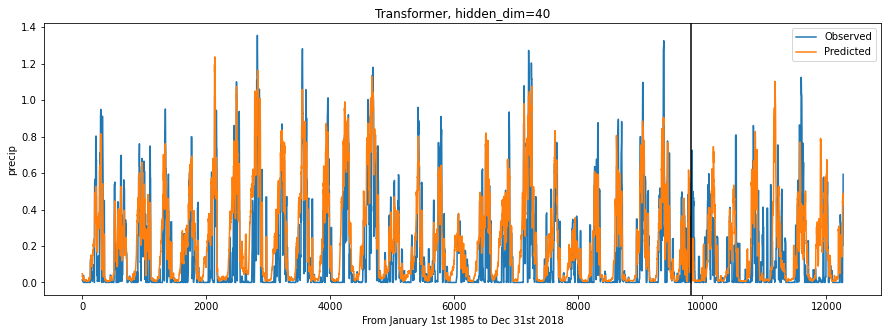

In [56]:
print('r-sq on train:', r2_score(y_all[train_window:-test_size], res[train_window:-test_size]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size:]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window:-test_size].reshape((1,-1)), res[train_window:-test_size].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  res[-test_size:].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window:],label='Observed')
plt.plot(res[train_window:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer, hidden_dim=40')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

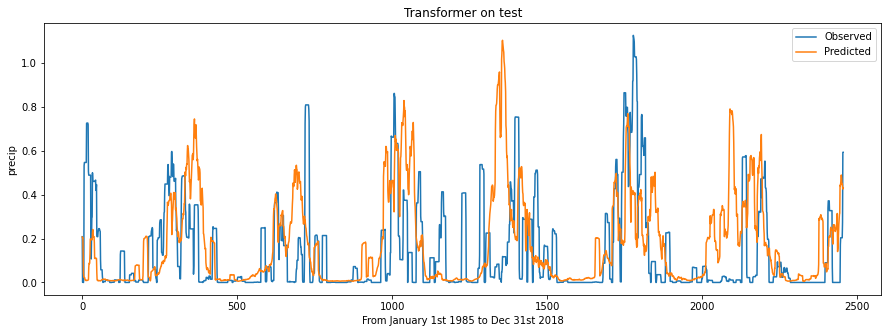

In [57]:
plt.figure(figsize=(15,5))
plt.plot(y_all[-test_size:],label='Observed')
plt.plot(res[-test_size:],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer on test');

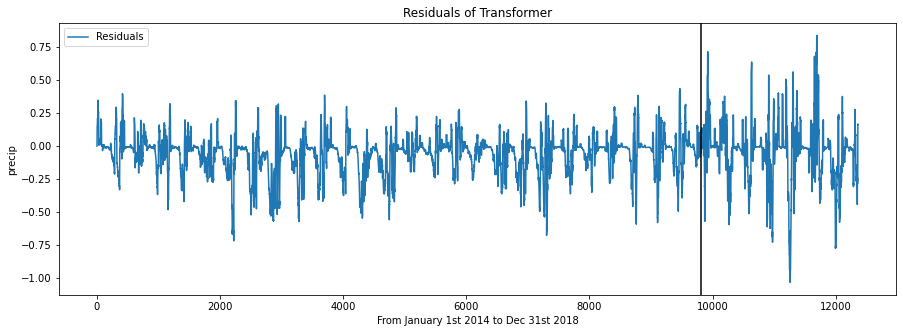

In [59]:
plt.figure(figsize=(15,5))
plt.plot(y_all - res ,label='Residuals')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Residuals of Transformer');
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

In [60]:
class XGBoost():
    def __init__(self, num_models=3274, base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
                 min_child_weight=1, missing=None, n_estimators=100,
                 n_jobs=16, nthread=None, objective='reg:squarederror',
                 random_state=0, reg_alpha=0, reg_lambda=1,
                 scale_pos_weight=1, seed=None, silent=True, subsample=1):


        """ Initilize a list of XGBoost 
        """
        super().__init__()    

        self.models = [xgb.XGBRegressor(objective=objective, max_depth=max_depth, learning_rate=learning_rate,
                                        colsample_bytree=colsample_bytree, n_estimators=n_estimators, gamma=gamma,
                                        base_score=base_score, booster=booster, colsample_bylevel=colsample_bylevel,
                                        max_delta_step=max_delta_step, min_child_weight=min_child_weight, missing=missing,
                                        n_jobs=1, nthread=nthread, random_state=random_state,
                                        reg_alpha=reg_alpha, reg_lambda=reg_lambda,
                                        scale_pos_weight=scale_pos_weight, seed=seed,
                                        silent=silent, subsample=subsample, tree_method='gpu_hist', n_gpus=1) for i in range(num_models)]
        self.n_jobs = n_jobs
        self.num_models = num_models



    def fit(self, X, y):

        """ fit XGBoost model at each location
        """
        self.models = Parallel(n_jobs=self.n_jobs)(delayed(self.models[loc].fit)(X, y[:, loc]) for loc in range(self.num_models))# 197x2x num_estimators


        return self.models
  

    def fit_cv(self, train_x, train_y, val_x, val_y):

        """ For hyper-parameter tuning: fit XGBoost model at each location
        """
        history = np.asarray(Parallel(n_jobs=self.n_jobs)(delayed(self.fit_single_output)
                                                          (self.models[loc], train_x, train_y[:, loc], val_x, val_y[:, loc])
                                                          for loc in range(self.num_models)))# 197x2x num_estimators

        return history


    def predict(self, X):
        """ For XGBoost model at each location, make prediction
        """
        pred_y = np.asarray((Parallel(n_jobs=self.n_jobs)(delayed(self.models[loc].predict)(X) for loc in range(self.num_models))))# 197x2x num_estimators


        return pred_y.T


    def fit_single_output(self, mdl, train_x, train_y, test_x, test_y):
        """ For hyper-parameter tuning: fit XGBoost model at each location
        """
        eval_set = [(train_x, train_y), (test_x, test_y)]
        eval_metric = ['rmse']

        mdl.fit(train_x, train_y, eval_metric=eval_metric, eval_set=eval_set, verbose=True)


        train_eval = mdl.evals_result()['validation_0']['rmse']
        test_eval = mdl.evals_result()['validation_1']['rmse']


        return train_eval, test_eval

In [70]:
train_seq_x = np.array(X_train)
train_seq_y = np.array(y_train-trend[0:y_train.shape[0]])

test_seq_x = np.array(X_test)


In [71]:
y_train.shape,y_test.shape,trend.shape

(torch.Size([9934, 1]), (2456, 1), (12390, 1))

In [72]:
mdl = XGBoost(num_models=1, n_jobs=1)
mdl.fit(train_seq_x, train_seq_y)
pred_train = mdl.predict(train_seq_x)+trend[0:y_train.shape[0]]
pred_test = mdl.predict(test_seq_x)+trend[y_train.shape[0]:]

[05:13:39] WARNING: ../include/xgboost/generic_parameters.h:35: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.
[05:13:39] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[05:13:39] WARNING: ../include/xgboost/generic_parameters.h:35: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.


In [73]:
target = 'precip'

r-sq on train: 0.9028712252622173
r-sq on test: 0.008726789747521613
cosine_similarity on train: [[0.97153667]]
cosine_similarity on test: [[0.6232627]]


Text(0.5, 1.0, 'XGBoost, hid_dim=40')

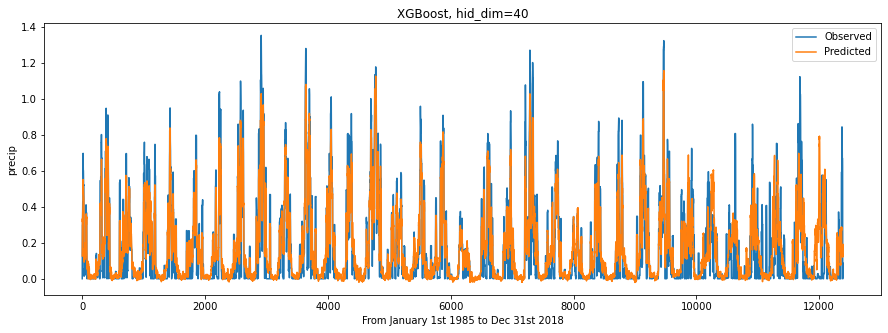

In [74]:
print('r-sq on train:', r2_score(y_train, pred_train))
print('r-sq on test:', r2_score(y_test,  pred_test))
print('cosine_similarity on train:', cosine_similarity(y_train.reshape((1,-1)), pred_train.reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_test.reshape((1,-1)),  pred_test.reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(np.concatenate((y_train, y_test)),label='Observed')
plt.plot(np.concatenate((pred_train, pred_test)),label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('XGBoost, hid_dim=40')
# plt.axvline(x=X.shape[0]- test_size,c='black');

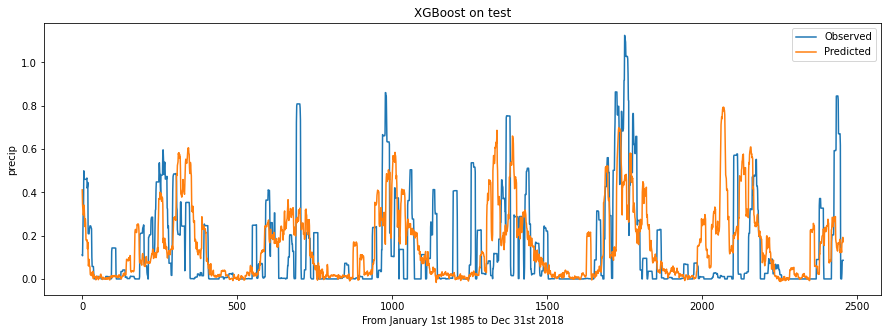

In [75]:
plt.figure(figsize=(15,5))
plt.plot(y_test,label='Observed')
plt.plot(pred_test,label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('XGBoost on test');

In [80]:
mdl = MLPRegressor(hidden_layer_sizes=(1000,500,250,100,50),alpha=0.1)
mdl.fit(X_train, (y_train-trend[0:y_train.shape[0]]).reshape((-1)))
pred_train = mdl.predict(X_train).reshape((-1,1))+trend[0:y_train.shape[0]]
pred_test = mdl.predict(X_test).reshape((-1,1))+trend[y_train.shape[0]:]

In [81]:
y_train.shape,pred_train.shape

(torch.Size([9934, 1]), (9934, 1))

r-sq on train: 0.8190759226441291
r-sq on test: 0.010104465533218865
cosine_similarity on train: [[0.96600801]]
cosine_similarity on test: [[0.58304119]]


Text(0.5, 1.0, 'MLP with layer sizes (1000,500,250,100,50) , hid_dim=40')

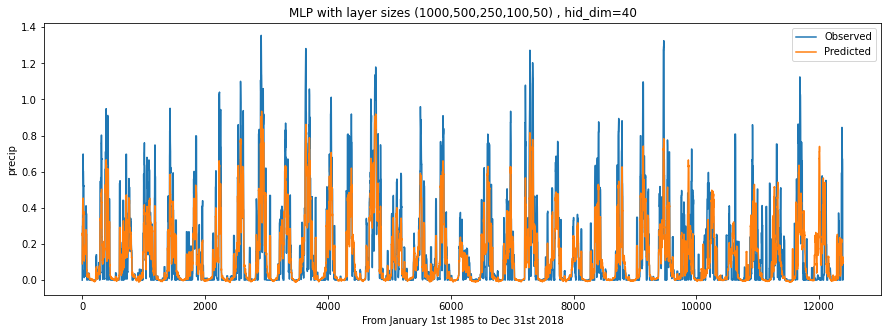

In [82]:
print('r-sq on train:', r2_score(y_train, pred_train))
print('r-sq on test:', r2_score(y_test,  pred_test))
print('cosine_similarity on train:', cosine_similarity(y_train.reshape((1,-1)), pred_train.reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_test.reshape((1,-1)),  pred_test.reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(np.concatenate((y_train, y_test)),label='Observed')
plt.plot(np.concatenate((pred_train, pred_test)),label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('MLP with layer sizes (1000,500,250,100,50) , hid_dim=40')
# plt.axvline(x=X.shape[0]- test_size,c='black');

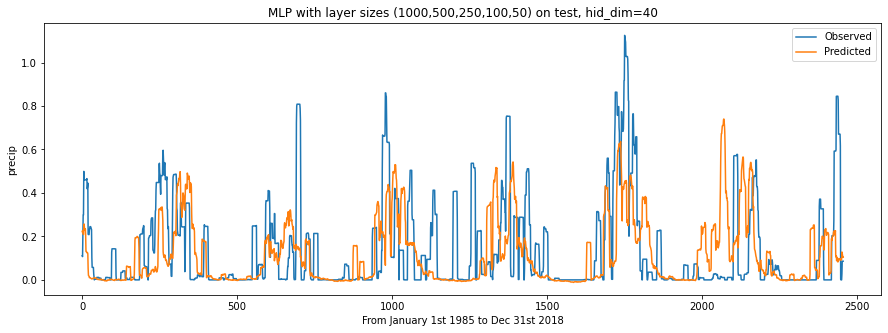

In [83]:
plt.figure(figsize=(15,5))
plt.plot(y_test,label='Observed')
plt.plot(pred_test,label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('MLP with layer sizes (1000,500,250,100,50) on test, hid_dim=40');